In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
sess =tf.Session()

In [2]:
mnist = tf.keras.datasets.mnist
(train_data,train_label),(test_data,test_label) = mnist.load_data()

train_shape = np.shape(train_data)
N_train = train_shape[0]
data_dim = train_data.shape[1]
minibatch_size = 500

Normalizing the data to make learning faster.

In [3]:
train_data = train_data/256.0
test_data = test_data/256.0

RNN unit with propagate function

In [4]:
class RNN:
    def __init__(self,dim):
        self.W = tf.Variable(tf.truncated_normal([dim,dim ], stddev=0.1))
        self.U = tf.Variable(tf.truncated_normal([dim,dim ], stddev=0.1))
        self.b = tf.Variable(np.zeros((1,dim)),dtype=tf.float32)
        
        self.V = tf.Variable(tf.truncated_normal([dim, 10], stddev=0.1))
        self.c = tf.Variable(np.zeros(10),dtype=tf.float32)
        
        self.h0 = tf.Variable(tf.truncated_normal([1,dim], stddev=0.1))
        
        self.dim = dim

    def propagate(self,x):
        h_run = self.h0
        X = tf.transpose(x,[1,0,2])
        for i in range(self.dim):
            a = self.b + tf.matmul(h_run,self.U) 
            a = a + tf.matmul(x[:,i,:],self.W)
            h_run = tf.tanh(a)
        
        o = self.c + tf.matmul(h_run,self.V)
        y = tf.nn.softmax(o)
        return y
            

Initializing the placeholders for the data

In [5]:
train_x = tf.placeholder(tf.float32,(minibatch_size,data_dim,data_dim))
train_y = tf.placeholder(tf.int32,(minibatch_size,))

In [6]:
rnn = RNN(data_dim)
output_value = rnn.propagate(train_x)

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(train_y,10),logits=output_value))

In [8]:
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)

In [9]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [10]:
# minibatching because the training is super slow with the whole dataset.

loss_arr = []
for i in range(10000):
    rand_index = np.random.choice(N_train, size=minibatch_size)
    t_x = train_data[rand_index]
    t_y = train_label[rand_index]    
    _, loss_value = sess.run([train,loss],feed_dict={train_x:t_x,train_y:t_y})
    loss_arr.append(loss_value)


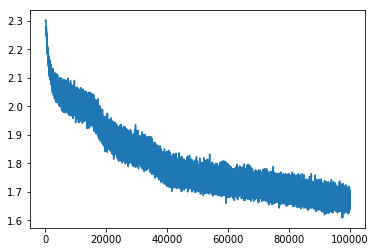

In [11]:
plt.plot(np.arange(len(loss_arr)),loss_arr)
#plt.savefig("LSTM-MNIST-err")
plt.show()


In [12]:
def batch_eval(data,label):
    print(data.shape)
    
    ypred = []
    for i in range(int(data.shape[0]/minibatch_size)):
        
        t_x = data[i*minibatch_size:(i+1)*minibatch_size]
        t_y = label[i*minibatch_size:(i+1)*minibatch_size]   
        soft_pred = sess.run(output_value,feed_dict={train_x:t_x,train_y:t_y})
        pred = np.argmax(soft_pred,axis=1)
        ypred.append(pred)
    return np.reshape(np.array(ypred),(-1))

In [13]:
ypred = batch_eval(train_data,train_label)
print("Accuracy on training data: %.3f"%(np.mean(np.equal(ypred,train_label))*100))

(60000, 28, 28)
Accuracy on training data: 79.363


In [14]:
ypred = batch_eval(test_data,test_label)
print("Accuracy on test data: %.3f"%(np.mean(np.equal(ypred,test_label))*100))

(10000, 28, 28)
Accuracy on test data: 79.410
